In [1]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install -q numpy scipy pandas h5py matplotlib torch torchvision tensorboardX numba plyfile tqdm scikit-learn
!pip install -q numpy-quaternion


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 16.1 MB/s eta 0:00:00


# *Core Imports*

In [3]:
from matplotlib.gridspec import GridSpec
from pathlib import Path
import zipfile, shutil, os
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt


# **Data Loading and Pre-processing**

In [14]:
# if running on drive

# RoNIN dataset and seen & unseen test set (.zip)
DATA_DIR = '/content/drive/MyDrive/GPSRoNIN/FRDR_dataset/Data'

# RoNIN Model
MODEL_DIR = '/content/drive/MyDrive/GPSRoNIN/FRDR_dataset/Pretrained_Models'

# Developed model
PROJECT_DIR = '/content/drive/MyDrive/GPSRoNIN/gps-imu-project'


os.makedirs(PROJECT_DIR, exist_ok=True)
print("Setup complete")

Setup complete


In [15]:

zip_seen   = Path(DATA_DIR) / 'modified_seen_subjects_test_set.zip'
zip_unseen = Path(DATA_DIR) / 'modified_unseen_test_set.zip'
out_seen   = Path(DATA_DIR) / 'seen_subjects_test_set'
out_unseen = Path(DATA_DIR) / 'unseen_subjects_test_set'

def force_extract_flatOld(zpath: Path, dest: Path, preferred_inner_names=('modified_seen_subjects_test_set','modified_unseen_test_set')):
    if not zpath.exists():
        print(f"[missing] {zpath}")
        return
    if dest.exists():
        print(f"[rm] {dest}")
        shutil.rmtree(dest)
    tmp = dest.with_name(dest.name + '__tmp')
    if tmp.exists():
        shutil.rmtree(tmp)
    print(f"[extract] {zpath.name} -> {tmp.name}")
    with zipfile.ZipFile(zpath, 'r') as z:
        z.extractall(tmp)

    mac = tmp / '__MACOSX'
    if mac.exists():
        shutil.rmtree(mac, ignore_errors=True)

    items = [p for p in tmp.iterdir()]

    if len(items) == 1 and items[0].is_dir():
        inner = items[0]
        print(f"[inner] {inner.name} -> {dest.name}")
        inner.rename(dest)
        shutil.rmtree(tmp, ignore_errors=True)
    else:

        inner = None
        for cand in items:
            if cand.is_dir() and cand.name in preferred_inner_names:
                inner = cand
                break
        if inner is None:

            dirs = [p for p in items if p.is_dir()]
            inner = dirs[0] if dirs else None
        dest.mkdir(parents=True, exist_ok=True)
        if inner is not None:

            for child in inner.iterdir():
                shutil.move(str(child), str(dest))
        else:

            for child in items:
                shutil.move(str(child), str(dest))
        shutil.rmtree(tmp, ignore_errors=True)

    nested = dest / 'modified_seen_subjects_test_set'
    if nested.exists() and nested.is_dir():
        for child in nested.iterdir():
            shutil.move(str(child), str(dest))
        shutil.rmtree(nested, ignore_errors=True)

    nested2 = dest / 'modified_unseen_test_set'
    if nested2.exists() and nested2.is_dir():
        for child in nested2.iterdir():
            shutil.move(str(child), str(dest))
        shutil.rmtree(nested2, ignore_errors=True)


def force_extract_flat(zpath: Path, dest: Path, preferred=('modified_seen_subjects_test_set','modified_unseen_test_set')):
    zpath, dest = Path(zpath), Path(dest)


    if dest.exists():
        shutil.rmtree(dest, ignore_errors=True)
    tmp = dest.with_name(dest.name + '__tmp')
    if tmp.exists():
        shutil.rmtree(tmp, ignore_errors=True)

    tmp.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(zpath, 'r') as z:
        z.extractall(tmp)

    items = [p for p in tmp.iterdir() if p.is_dir()]
    inner = None
    if len(items) == 1:
        inner = items[0]
    else:
        inner = next((p for p in items if p.name in preferred), (items[0] if items else None))

    dest.mkdir(parents=True, exist_ok=True)
    if inner is not None:
        for child in inner.iterdir():
            shutil.move(str(child), str(dest))
    else:
        for child in tmp.iterdir():
            shutil.move(str(child), str(dest))

    shutil.rmtree(tmp, ignore_errors=True)

def verify_gps(split_dir: Path, show=10):
    seqs = [p for p in split_dir.iterdir() if p.is_dir() and (p/'data.hdf5').exists()]
    print(f"[{split_dir.name}] sequences: {len(seqs)}")
    with_gps = 0
    for p in seqs[:show]:
        g = (p/'data_gps.csv').exists()
        print(f"  - {p.name}: data_gps.csv={'yes' if g else 'no'}")
        with_gps += int(g)
    for p in seqs[show:]:
        if (p/'data_gps.csv').exists():
            with_gps += 1
    print(f"  -> sequences with GPS CSV: {with_gps}/{len(seqs)}")


force_extract_flat(zip_seen, out_seen, preferred=('modified_seen_subjects_test_set',))
force_extract_flat(zip_unseen, out_unseen, preferred=('modified_unseen_test_set',))

verify_gps(out_seen)
verify_gps(out_unseen)


[seen_subjects_test_set] sequences: 35
  - a034_2: data_gps.csv=yes
  - a030_3: data_gps.csv=yes
  - a011_2: data_gps.csv=yes
  - a005_3: data_gps.csv=yes
  - a009_1: data_gps.csv=yes
  - a001_2: data_gps.csv=yes
  - a020_2: data_gps.csv=yes
  - a033_2: data_gps.csv=yes
  - a012_2: data_gps.csv=yes
  - a027_2: data_gps.csv=yes
  -> sequences with GPS CSV: 35/35
[unseen_subjects_test_set] sequences: 32
  - a055_3: data_gps.csv=yes
  - a051_2: data_gps.csv=yes
  - a032_1: data_gps.csv=yes
  - a053_1: data_gps.csv=yes
  - a057_1: data_gps.csv=yes
  - a055_2: data_gps.csv=yes
  - a051_3: data_gps.csv=yes
  - a024_3: data_gps.csv=yes
  - a049_1: data_gps.csv=yes
  - a052_2: data_gps.csv=yes
  -> sequences with GPS CSV: 32/32


In [16]:

SEEN_DIR   = f'{DATA_DIR}/seen_subjects_test_set'
UNSEEN_DIR = f'{DATA_DIR}/unseen_subjects_test_set'

SEEN_LIST   = f'{PROJECT_DIR}/test_list_seen.txt'
UNSEEN_LIST = f'{PROJECT_DIR}/test_list_unseen.txt'

def build_list(root_dir, list_path):
    seqs = [p.name for p in Path(root_dir).iterdir() if (p/'data.hdf5').exists()]
    with open(list_path, 'w') as f:
        for s in sorted(seqs):
            f.write(s + '\n')
    print(f"[list] {len(seqs)} → {list_path}")

build_list(SEEN_DIR, SEEN_LIST)
build_list(UNSEEN_DIR, UNSEEN_LIST)

[list] 35 → /content/drive/MyDrive/GPSRoNIN/gps-imu-project/test_list_seen.txt
[list] 32 → /content/drive/MyDrive/GPSRoNIN/gps-imu-project/test_list_unseen.txt


# **Inference pipeline of RoNIN Position Network**

In [17]:

RONIN_OUT_DIR = f'{PROJECT_DIR}/ronin_predictions'
os.makedirs(RONIN_OUT_DIR, exist_ok=True)

resnet_zip = Path(MODEL_DIR) / 'ronin_resnet.zip'
resnet_dir = Path(MODEL_DIR) / 'ronin_resnet'

if resnet_zip.exists() and not resnet_dir.exists():
    print("Extracting RoNIN ResNet model...")
    with zipfile.ZipFile(resnet_zip, 'r') as z:
        z.extractall(MODEL_DIR)
    print("Model extracted successfully!")
elif resnet_dir.exists():
    print("Model already extracted")

ckpts = glob.glob(str(resnet_dir / '*.pt'))
if not ckpts:
    raise FileNotFoundError(f"ERROR: No checkpoint found in {resnet_dir}")
else:
    MODEL_PATH = ckpts[0]
    print(f"Found checkpoint: {MODEL_PATH}\n")


# Clone RoNIN Repository
print("Setting Up RoNIN Repository")

ronin_repo_path = Path(PROJECT_DIR) / 'ronin'

if not ronin_repo_path.exists():
    print("Cloning RoNIN repository...")
    %cd {PROJECT_DIR}
    !git clone https://github.com/Sachini/ronin.git
    print("RoNIN repository cloned successfully!")
else:
    print("RoNIN repository already exists")
ronin_script = ronin_repo_path / 'source' / 'ronin_resnet.py'
if not ronin_script.exists():
    raise FileNotFoundError(f"ERROR: ronin_resnet.py not found at {ronin_script}")
print(f"Found ronin_resnet.py\n")

with open(ronin_script, 'r') as f:
    content = f.read()

original_content = content
content = content.replace('dtype=np.int)', 'dtype=int)')
content = content.replace('dtype=np.int,', 'dtype=int,')
content = content.replace('dtype=np.int ', 'dtype=int ')

if content != original_content:
    with open(ronin_script, 'w') as f:
        f.write(content)
    print("Patched ronin_resnet.py for NumPy compatibility!")
else:
    print("Script already compatible (no changes needed)\n")


# Run Inference on SEEN Subjects
print("Running RoNIN ResNet on SEEN Subjects")

%cd {PROJECT_DIR}/ronin

!python source/ronin_resnet.py \
    --mode test \
    --test_list "{SEEN_LIST}" \
    --root_dir "{SEEN_DIR}" \
    --out_dir "{RONIN_OUT_DIR}/seen" \
    --model_path "{MODEL_PATH}"

print("SEEN inference completed!\n")

# Run Inference on UNSEEN Subjects
print("Running RoNIN ResNet on UNSEEN Subjects")

!python source/ronin_resnet.py \
    --mode test \
    --test_list "{UNSEEN_LIST}" \
    --root_dir "{UNSEEN_DIR}" \
    --out_dir "{RONIN_OUT_DIR}/unseen" \
    --model_path "{MODEL_PATH}"

%cd {PROJECT_DIR}

print("UNSEEN inference completed!\n")


# Verify RoNIN Outputs
def verify_ronin_outputs(out_dir, data_root):
    out_path = Path(out_dir)
    data_path = Path(data_root)

    npy_files = list(out_path.glob('*.npy'))
    print(f"\n{'=' * 70}")
    print(f"Found {len(npy_files)} output files in {out_path.name}")
    print(f"{'=' * 70}")

    if len(npy_files) == 0:
        print("WARNING: No output files found!")
        return None


    for i, npy_file in enumerate(npy_files[:3]):
        seq_name = npy_file.stem.replace('_gsn', '')
        print(f"\n--- Sequence {i+1}: {seq_name} ---")

        ronin_data = np.load(npy_file)
        print(f"  RoNIN output shape: {ronin_data.shape}")
        print(f"  RoNIN output dtype: {ronin_data.dtype}")

        seq_dir = data_path / seq_name
        if not seq_dir.exists():
            print(f" Warning: Sequence directory not found: {seq_dir}")
            continue

        # Load ground truth
        with h5py.File(seq_dir / 'data.hdf5', 'r') as f:
            gt_pos = np.array(f['pose']['tango_pos'])[:, :2]
            time = np.array(f['synced']['time'])

        print(f"  Ground truth shape: {gt_pos.shape}")
        print(f"  Time array shape: {time.shape}")

        # Load metadata
        info_file = seq_dir / 'info.json'
        if info_file.exists():
            with open(info_file, 'r') as f:
                info = json.load(f)
                start_frame = info.get('start_frame', 0)
            print(f"  Start frame: {start_frame}")

        # Check for GPS data
        gps_file = seq_dir / 'data_gps.csv'
        if gps_file.exists():
            gps_df = pd.read_csv(gps_file)
            print(f"  GPS data shape: {gps_df.shape}")
            print(f"  GPS columns: {list(gps_df.columns)}")
        else:
            print("  No GPS data found")

    if len(npy_files) > 3:
        print(f"\n... and {len(npy_files) - 3} more sequences")

    return npy_files


print("Verifying Outputs")

print("\nVerifying SEEN outputs...")
seen_files = verify_ronin_outputs(f"{RONIN_OUT_DIR}/seen", SEEN_DIR)
print("\n\nVerifying UNSEEN outputs...")
unseen_files = verify_ronin_outputs(f"{RONIN_OUT_DIR}/unseen", UNSEEN_DIR)



Model already extracted
Found checkpoint: /content/drive/MyDrive/GPSRoNIN/FRDR_dataset/Pretrained_Models/ronin_resnet/checkpoint_gsn_latest.pt

Setting Up RoNIN Repository
Cloning RoNIN repository...
/content/drive/MyDrive/GPSRoNIN/gps-imu-project
Cloning into 'ronin'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 54 (delta 13), reused 9 (delta 9), pack-reused 8 (from 1)
Receiving objects: 100% (54/54), 69.39 KiB | 3.65 MiB/s, done.
Resolving deltas: 100% (13/13), done.
RoNIN repository cloned successfully!
Found ronin_resnet.py

Patched ronin_resnet.py for NumPy compatibility!
Running RoNIN ResNet on SEEN Subjects
/content/drive/MyDrive/GPSRoNIN/gps-imu-project/ronin
a000_11: device: asus6, ori_error (game_rv): 16.363
Model /content/drive/MyDrive/GPSRoNIN/FRDR_dataset/Pretrained_Models/ronin_resnet/checkpoint_gsn_latest.pt loaded to device cuda:0.
a000_11: device: asus6, ori_error (

PROCESSING SEEN SEQUENCES
Plotting 2 out of 35 SEEN sequences

Processing SEEN 1/2: a000_11
Saved: /content/drive/MyDrive/GPSRoNIN/gps-imu-project/trajectory_plots/seen/a000_11_comparison.png


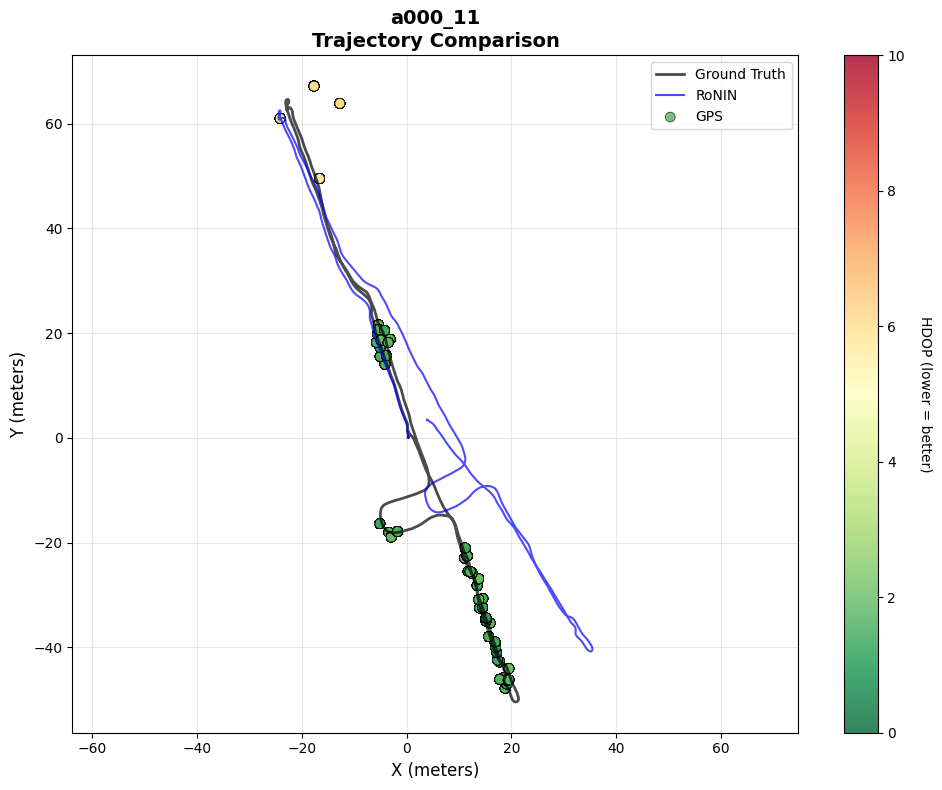

Processing SEEN 2/2: a000_7
Saved: /content/drive/MyDrive/GPSRoNIN/gps-imu-project/trajectory_plots/seen/a000_7_comparison.png


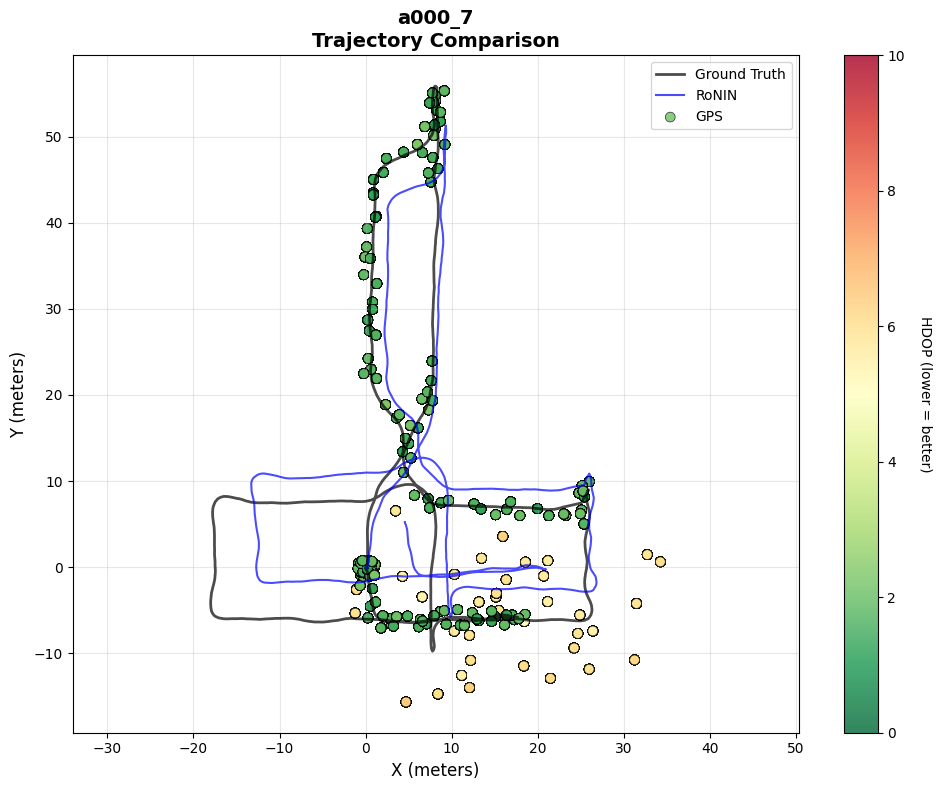


SEEN plots saved to: /content/drive/MyDrive/GPSRoNIN/gps-imu-project/trajectory_plots/seen

PROCESSING UNSEEN SEQUENCES
Plotting 2 out of 32 UNSEEN sequences

Processing UNSEEN 1/2: a006_2
Saved: /content/drive/MyDrive/GPSRoNIN/gps-imu-project/trajectory_plots/unseen/a006_2_comparison.png


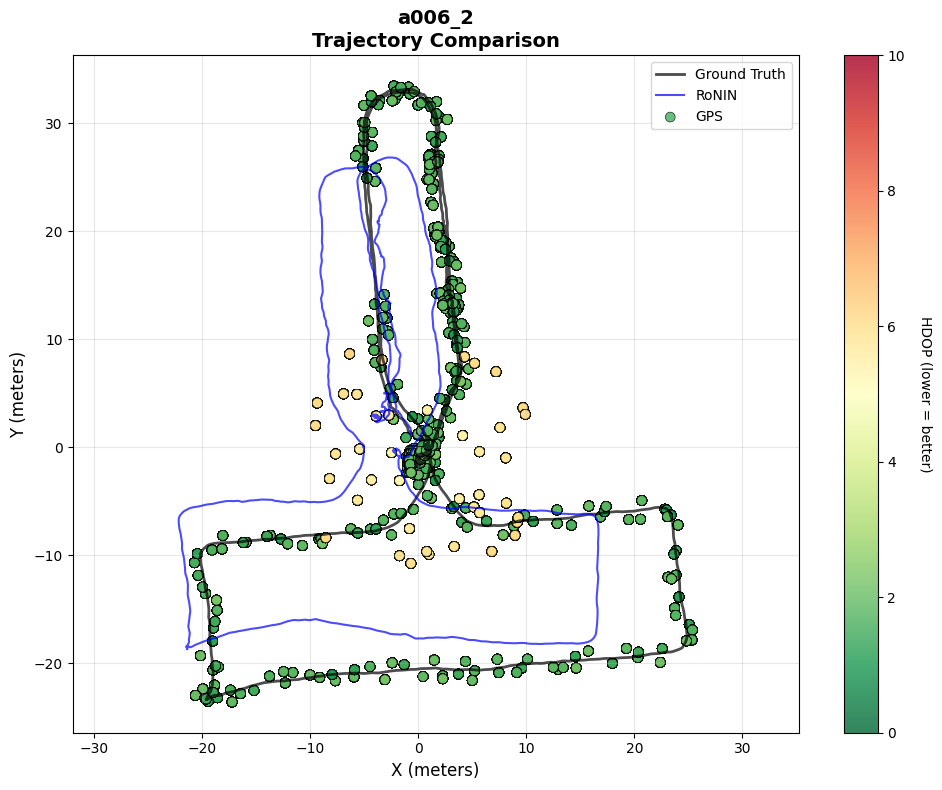

Processing UNSEEN 2/2: a019_3
Saved: /content/drive/MyDrive/GPSRoNIN/gps-imu-project/trajectory_plots/unseen/a019_3_comparison.png


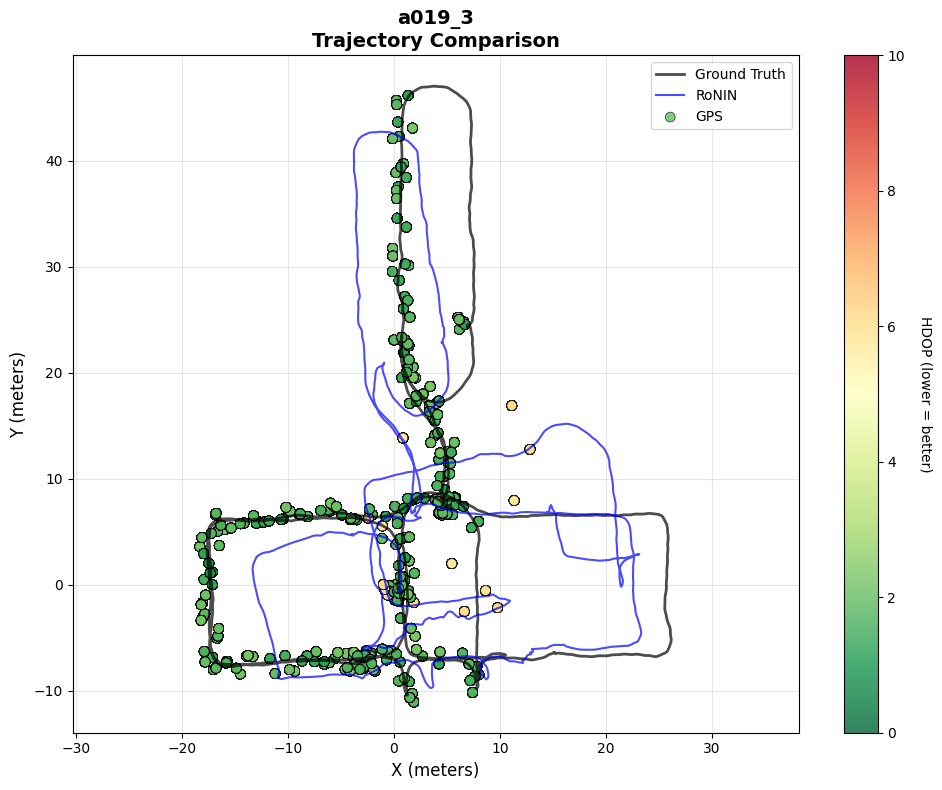


UNSEEN plots saved to: /content/drive/MyDrive/GPSRoNIN/gps-imu-project/trajectory_plots/unseen

Total SEEN sequences: 35
Total UNSEEN sequences: 32


In [18]:
RONIN_SEEN_DIR = f'{PROJECT_DIR}/ronin_predictions/seen'
RONIN_UNSEEN_DIR = f'{PROJECT_DIR}/ronin_predictions/unseen'

def load_sequence_data(seq_name, ronin_dir, data_root):
    ronin_path = Path(ronin_dir)
    data_path = Path(data_root) / seq_name

    ronin_file = ronin_path / f'{seq_name}_gsn.npy'
    if not ronin_file.exists():
        return None

    ronin_pos = np.load(ronin_file).astype(np.float32)[:, :2]

    with h5py.File(data_path / 'data.hdf5', 'r') as f:
        gt_pos = np.array(f['pose']['tango_pos'])[:, :2].astype(np.float32)
        time = np.array(f['synced']['time']).astype(np.float32)

    info_file = data_path / 'info.json'
    start_frame = 0
    if info_file.exists():
        with open(info_file, 'r') as f:
            start_frame = int(json.load(f).get('start_frame', 0))

    # Align lengths
    T = min(len(ronin_pos), len(gt_pos), len(time))
    ronin_pos = ronin_pos[:T]
    gt_pos = gt_pos[start_frame:start_frame+T]
    time = time[start_frame:start_frame+T]

    gps_file = data_path / 'data_gps.csv'
    gps_aligned = np.full((T, 3), np.nan)

    if gps_file.exists():
        gps_df = pd.read_csv(gps_file)


        rename_map = {}
        for col in gps_df.columns:
            col_lower = col.lower()
            if 'time' in col_lower:
                rename_map[col] = 'time_s'
            elif col_lower.startswith('x') or 'x_m' in col_lower:
                rename_map[col] = 'x_m'
            elif col_lower.startswith('y') or 'y_m' in col_lower:
                rename_map[col] = 'y_m'
            elif 'hdop' in col_lower:
                rename_map[col] = 'HDOP'

        gps_df = gps_df.rename(columns=rename_map)

        if 'HDOP' not in gps_df.columns:
            gps_df['HDOP'] = 5.0

        if all(col in gps_df.columns for col in ['time_s', 'x_m', 'y_m', 'HDOP']):
            gps_t = gps_df['time_s'].to_numpy()
            gps_x = gps_df['x_m'].to_numpy()
            gps_y = gps_df['y_m'].to_numpy()
            gps_hdop = gps_df['HDOP'].to_numpy()

            tol = max(0.5, 2.0 * np.median(np.diff(gps_t)) if len(gps_t) > 1 else 1.0)

            for i, t in enumerate(time):
                idx = np.argmin(np.abs(gps_t - t))
                if np.abs(gps_t[idx] - t) < tol:
                    gps_aligned[i] = [gps_x[idx], gps_y[idx], gps_hdop[idx]]

    return {
        'seq_name': seq_name,
        'ronin_pos': ronin_pos,
        'gps_pos': gps_aligned[:, :2],
        'gps_hdop': gps_aligned[:, 2],
        'gt_pos': gt_pos,
        'time': time,
        'start_frame': start_frame
    }


def plot_trajectory_comparison(data, save_path=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    gps_mask = np.isfinite(data['gps_pos']).all(axis=1)
    gps_valid = data['gps_pos'][gps_mask]
    hdop_valid = data['gps_hdop'][gps_mask]

    # Plot trajectories
    ax.plot(data['gt_pos'][:, 0], data['gt_pos'][:, 1], 'k-',
            linewidth=2, label='Ground Truth', alpha=0.7)
    ax.plot(data['ronin_pos'][:, 0], data['ronin_pos'][:, 1], 'b-',
            linewidth=1.5, label='RoNIN', alpha=0.7)

    if len(gps_valid) > 0:
        scatter = ax.scatter(gps_valid[:, 0], gps_valid[:, 1],
                           c=hdop_valid, cmap='RdYlGn_r', vmin=0, vmax=10,
                           s=50, label='GPS', alpha=0.8,
                           edgecolors='black', linewidth=0.5)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('HDOP (lower = better)', rotation=270, labelpad=20)

    ax.set_xlabel('X (meters)', fontsize=12)
    ax.set_ylabel('Y (meters)', fontsize=12)
    ax.set_title(f'{data["seq_name"]}\nTrajectory Comparison',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()


# Process SEEN sequences
print("PROCESSING SEEN SEQUENCES")

ronin_path_seen = Path(RONIN_SEEN_DIR)
available_seqs_seen = [f.stem.replace('_gsn', '') for f in ronin_path_seen.glob('*_gsn.npy')]

plot_dir_seen = Path(PROJECT_DIR) / 'trajectory_plots' / 'seen'
plot_dir_seen.mkdir(parents=True, exist_ok=True)

num_to_plot_seen = min(2, len(available_seqs_seen))
print(f"Plotting {num_to_plot_seen} out of {len(available_seqs_seen)} SEEN sequences\n")

for i, seq_name in enumerate(available_seqs_seen[:num_to_plot_seen]):
    print(f"Processing SEEN {i+1}/{num_to_plot_seen}: {seq_name}")

    data = load_sequence_data(seq_name, RONIN_SEEN_DIR, SEEN_DIR)

    if data is not None:
        save_path = plot_dir_seen / f'{seq_name}_comparison.png'
        plot_trajectory_comparison(data, save_path=save_path)
    else:
        print(f"Failed to load data for {seq_name}")

print(f"\nSEEN plots saved to: {plot_dir_seen}\n")



# Process UNSEEN sequences
print("PROCESSING UNSEEN SEQUENCES")

ronin_path_unseen = Path(RONIN_UNSEEN_DIR)
available_seqs_unseen = [f.stem.replace('_gsn', '') for f in ronin_path_unseen.glob('*_gsn.npy')]

plot_dir_unseen = Path(PROJECT_DIR) / 'trajectory_plots' / 'unseen'
plot_dir_unseen.mkdir(parents=True, exist_ok=True)

num_to_plot_unseen = min(2, len(available_seqs_unseen))
print(f"Plotting {num_to_plot_unseen} out of {len(available_seqs_unseen)} UNSEEN sequences\n")

for i, seq_name in enumerate(available_seqs_unseen[:num_to_plot_unseen]):
    print(f"Processing UNSEEN {i+1}/{num_to_plot_unseen}: {seq_name}")

    data = load_sequence_data(seq_name, RONIN_UNSEEN_DIR, UNSEEN_DIR)

    if data is not None:
        save_path = plot_dir_unseen / f'{seq_name}_comparison.png'
        plot_trajectory_comparison(data, save_path=save_path)
    else:
        print(f"Failed to load data for {seq_name}")

print(f"\nUNSEEN plots saved to: {plot_dir_unseen}\n")


print(f"Total SEEN sequences: {len(available_seqs_seen)}")
print(f"Total UNSEEN sequences: {len(available_seqs_unseen)}")


# **GPS-Assisted Trajectory Prediction**



Device: cuda
Velocity Correction Approach


Loading (no alignment):   0%|          | 0/35 [00:00<?, ?it/s]

Stratified split: 26 train, 9 val
  Train GPS coverage: 50.6%
  Val GPS coverage: 62.0%
Dataset: 19387 windows (with augmentation)
  Features: [vx_r, vy_r, gps_x, gps_y, gps_vx, gps_vy, hdop, dt, gps_flag] = 9D
  Targets: velocity_corrections (2D)
Dataset: 3119 windows (with augmentation)
  Features: [vx_r, vy_r, gps_x, gps_y, gps_vx, gps_vy, hdop, dt, gps_flag] = 9D
  Targets: velocity_corrections (2D)


Epoch 1:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 1: Train=0.0418, Val=0.0463
  → Best model saved (val=0.0463)


Epoch 2:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 2: Train=0.0414, Val=0.0462
  → Best model saved (val=0.0462)


Epoch 3:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 3: Train=0.0412, Val=0.0465


Epoch 4:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 4: Train=0.0410, Val=0.0461
  → Best model saved (val=0.0461)


Epoch 5:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 5: Train=0.0405, Val=0.0462


Epoch 6:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 6: Train=0.0398, Val=0.0454
  → Best model saved (val=0.0454)


Epoch 7:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 7: Train=0.0394, Val=0.0458


Epoch 8:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 8: Train=0.0391, Val=0.0462


Epoch 9:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 9: Train=0.0389, Val=0.0465


Epoch 10:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 10: Train=0.0385, Val=0.0456


Epoch 11:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 11: Train=0.0378, Val=0.0459


Epoch 12:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 12: Train=0.0371, Val=0.0453
  → Best model saved (val=0.0453)


Epoch 13:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 13: Train=0.0370, Val=0.0455


Epoch 14:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 14: Train=0.0367, Val=0.0453
  → Best model saved (val=0.0453)


Epoch 15:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 15: Train=0.0365, Val=0.0457


Epoch 16:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 16: Train=0.0362, Val=0.0462


Epoch 17:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 17: Train=0.0361, Val=0.0453


Epoch 18:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 18: Train=0.0359, Val=0.0458


Epoch 19:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 19: Train=0.0354, Val=0.0456


Epoch 20:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 20: Train=0.0353, Val=0.0454


Epoch 21:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 21: Train=0.0350, Val=0.0457


Epoch 22:   0%|          | 0/606 [00:00<?, ?it/s]

Epoch 22: Train=0.0349, Val=0.0456
Early stopping at epoch 22


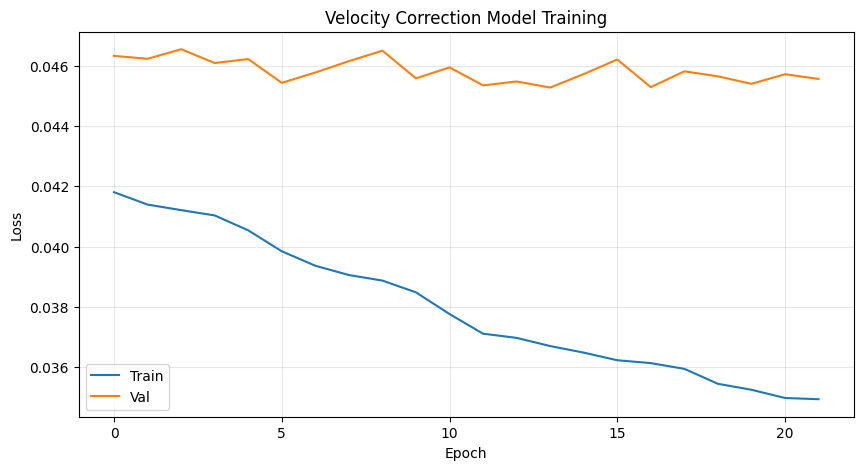

In [10]:


SEEN_DIR   = f'{DATA_DIR}/seen_subjects_test_set'
UNSEEN_DIR = f'{DATA_DIR}/unseen_subjects_test_set'

RONIN_SEEN_DIR = f'{PROJECT_DIR}/ronin_predictions/seen'
RONIN_UNSEEN_DIR = f'{PROJECT_DIR}/ronin_predictions/unseen'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")


def clamp_vec_norm(v, max_mag):
    n = np.linalg.norm(v, axis=-1, keepdims=True) + 1e-9
    scale = np.minimum(1.0, max_mag / n)
    return v * scale


def _safe_dt(t):
    t = np.asarray(t, float)
    dt = np.diff(t, prepend=t[0])
    pos = dt[np.isfinite(dt) & (dt > 0)]
    fill = np.median(pos) if pos.size else 0.1
    bad = ~np.isfinite(dt) | (dt <= 0)
    dt[bad] = fill
    return dt

def _ffill_2d(arr):

    a = np.asarray(arr, float).copy()
    finite = np.isfinite(a).all(axis=1)
    if not finite.any():
        return np.nan_to_num(a, nan=0.0)

    last = np.where(finite)[0][0]

    if last > 0:
        a[:last] = a[last]

    for i in range(last + 1, len(a)):
        if not np.isfinite(a[i]).all():
            a[i] = a[i - 1]
    return a

def load_aligned_sequences(seq_names, ronin_dir, data_root, hdop_thr=2.0):
    """
    - Loads raw sequences
    - Uses raw RoNIN positions (no rigid alignment to GT)
    - Computes velocities from raw RoNIN with safe dt and ffill for NaNs

    """
    out = []
    for seq_name in tqdm(seq_names, desc="Loading (no alignment)"):
        data = load_sequence_data(seq_name, ronin_dir, data_root)
        if data is None:
            continue

        # sanitize RoNIN positions for velocity computation
        ronin_pos = _ffill_2d(data['ronin_pos'])
        dt = _safe_dt(data['time'])

        ronin_vel = np.zeros_like(ronin_pos, dtype=float)
        if len(ronin_pos) > 1:
            ronin_vel[1:] = (ronin_pos[1:] - ronin_pos[:-1]) / dt[1:, None]
            ronin_vel[0] = ronin_vel[1]


        out.append({
            'seq_name'  : seq_name,
            'ronin_pos' : ronin_pos,                # RoNIN
            'ronin_vel' : ronin_vel,                # velocities from RoNIN
            'gps_pos'   : data.get('gps_pos'),      # may contain NaNs
            'gps_hdop'  : data.get('gps_hdop'),
            'gt_pos'    : data.get('gt_pos'),
            'time'      : data.get('time'),

        })

    return out


# VelocityCorrectionDataset

class VelocityCorrectionDataset(Dataset):
    def __init__(self, sequences, window=200, stride=100, min_gps_cov=0.05,
                 augment_gps_dropout=True, dropout_prob=0.3):

        self.samples = []

        for seq in sequences:
            T = len(seq['time'])
            dt = _safe_dt(seq['time'])

            gt_vel = np.zeros_like(seq['gt_pos'], dtype=float)
            if T > 1:
                gt_vel[1:] = (seq['gt_pos'][1:] - seq['gt_pos'][:-1]) / dt[1:, None]
                gt_vel[0] = gt_vel[1]
            vel_corr = (gt_vel - seq['ronin_vel']).astype(np.float32)

            gps_flag = np.isfinite(seq['gps_pos']).all(axis=1).astype(np.float32)
            gps_pos = _ffill_2d(seq['gps_pos'])
            gps_pos = np.nan_to_num(gps_pos, nan=0.0)

            gps_vel = np.zeros_like(gps_pos)
            if T > 1:
                gps_vel[1:] = (gps_pos[1:] - gps_pos[:-1]) / dt[1:, None]
                gps_vel[0] = gps_vel[1]

            gps_pos *= gps_flag[:, None]
            gps_vel *= gps_flag[:, None]
            hdop = np.nan_to_num(seq['gps_hdop'], nan=10.0).clip(0, 20.0)

            # Build feature matrix
            X = np.column_stack([
                seq['ronin_vel'],
                gps_pos,
                gps_vel,
                hdop[:, None],
                dt[:, None],
                gps_flag[:, None]
            ]).astype(np.float32)

            M = gps_flag[:, None].astype(np.float32)

            for i in range(0, T - window + 1, stride):
                if M[i:i+window].mean() < min_gps_cov:
                    continue

                X_window = X[i:i+window].copy()
                Y_window = vel_corr[i:i+window].copy()
                M_window = M[i:i+window].copy()

                self.samples.append({
                    'X': X_window,
                    'Y': Y_window,
                    'M': M_window
                })


                if augment_gps_dropout and np.random.rand() < dropout_prob:
                    X_aug = X_window.copy()
                    M_aug = M_window.copy()

                    dropout_len = np.random.randint(window // 5, int(window * 0.6))
                    dropout_start = np.random.randint(0, window - dropout_len)
                    dropout_end = dropout_start + dropout_len

                    # Zero out GPS positions and velocities
                    X_aug[dropout_start:dropout_end, 2:6] = 0
                    X_aug[dropout_start:dropout_end, 6] = 10.0
                    X_aug[dropout_start:dropout_end, 8] = 0
                    M_aug[dropout_start:dropout_end] = 0

                    self.samples.append({
                        'X': X_aug,
                        'Y': Y_window,
                        'M': M_aug
                    })

        print(f"Dataset: {len(self.samples)} windows (with augmentation)")
        print(f"  Features: [vx_r, vy_r, gps_x, gps_y, gps_vx, gps_vy, hdop, dt, gps_flag] = 9D")
        print(f"  Targets: velocity_corrections (2D)")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        X = np.nan_to_num(s['X'], nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        Y = np.nan_to_num(s['Y'], nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
        M = s['M'].astype(np.float32)
        return {
            'X': torch.tensor(X, dtype=torch.float32),
            'Y': torch.tensor(Y, dtype=torch.float32),
            'M': torch.tensor(M, dtype=torch.float32),
        }


def create_stratified_split(sequences, train_ratio=0.8):

    seq_with_coverage = []
    for seq in sequences:
        gps_mask = np.isfinite(seq['gps_pos']).all(axis=1)
        coverage = gps_mask.mean()
        seq_with_coverage.append((seq, coverage))

    seq_with_coverage.sort(key=lambda x: x[1])

    n = len(seq_with_coverage)
    low_cov = seq_with_coverage[:n//3]
    mid_cov = seq_with_coverage[n//3:2*n//3]
    high_cov = seq_with_coverage[2*n//3:]

    train_seqs = []
    val_seqs = []

    for bin_seqs in [low_cov, mid_cov, high_cov]:
        n_train = int(len(bin_seqs) * train_ratio)
        train_seqs.extend([s[0] for s in bin_seqs[:n_train]])
        val_seqs.extend([s[0] for s in bin_seqs[n_train:]])

    train_cov = np.mean([np.isfinite(s['gps_pos']).all(1).mean() for s in train_seqs])
    val_cov = np.mean([np.isfinite(s['gps_pos']).all(1).mean() for s in val_seqs])

    print(f"Stratified split: {len(train_seqs)} train, {len(val_seqs)} val")
    print(f"  Train GPS coverage: {train_cov*100:.1f}%")
    print(f"  Val GPS coverage: {val_cov*100:.1f}%")

    return train_seqs, val_seqs


# Model

class VelocityCorrectionLSTM(nn.Module):
    """
    for real-time inference: Unidirectional LSTM is suitable.
    """
    def __init__(self, input_dim=9, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=True
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        if not x.is_contiguous():
            x = x.contiguous()
        if hasattr(self.lstm, "flatten_parameters"):
            self.lstm.flatten_parameters()
        h, _ = self.lstm(x)
        return self.head(h)



# Loss Function

def weighted_correction_loss(pred_correction, target_correction, mask, hdop, lambda_mag=1e-3):
    """
    Supervise only where GPS exists (mask=1).
    Weight data-fit by 1/(1+hdop). Also penalize magnitude of corrections
    more when HDOP is low (good GPS) so the model learns to stay quiet.
    """
    valid = mask > 0.5

    target_safe = torch.where(valid.expand_as(target_correction),
                              target_correction,
                              pred_correction.detach())

    sqerr = (pred_correction - target_safe) ** 2
    w_fit = 1.0 / (1.0 + hdop.clamp(0, 20.0))
    w_fit = torch.where(valid, w_fit, torch.zeros_like(w_fit))
    fit_term = (w_fit * sqerr.mean(dim=-1, keepdim=True)).sum() / (w_fit.sum() + 1e-8)

    # magnitude regularizer: larger penalty when HDOP is small (good GPS)
    corr_mag2 = (pred_correction ** 2).sum(dim=-1, keepdim=True)
    w_reg = (1.0 / (1.0 + hdop.clamp(0, 20.0))).detach()
    reg_term = (w_reg * corr_mag2).mean()

    return fit_term + lambda_mag * reg_term



# Prediction Function

def predict_sequence_with_corrections(model, seq_data, device,
                                       hdop_threshold=2.0, max_correction=0.15):

    T = len(seq_data['time'])
    dt = _safe_dt(seq_data['time'])
    hdop = np.nan_to_num(seq_data['gps_hdop'], nan=10.0).clip(0, 20.0)
    gps_flag = np.isfinite(seq_data['gps_pos']).all(axis=1).astype(np.float32)

    gps_pos_in = _ffill_2d(seq_data['gps_pos'])
    gps_pos_in = np.nan_to_num(gps_pos_in, nan=0.0, posinf=0.0, neginf=0.0)

    gps_vel_in = np.zeros_like(gps_pos_in)
    if T > 1:
        gps_vel_in[1:] = (gps_pos_in[1:] - gps_pos_in[:-1]) / dt[1:, None]
        gps_vel_in[0] = gps_vel_in[1]

    gps_pos_in *= gps_flag[:, None]
    gps_vel_in *= gps_flag[:, None]

    # Build features
    features = np.column_stack([
        seq_data['ronin_vel'],
        gps_pos_in,
        gps_vel_in,
        hdop[:, None],
        dt[:, None],
        gps_flag[:, None],
    ]).astype(np.float32)
    features = np.ascontiguousarray(features)

    # Predict velocity corrections
    model.eval()
    corrections = []
    chunk = 5000
    with torch.no_grad():
        for i in range(0, T, chunk):
            end = min(i + chunk, T)
            Xnp = features[i:end]
            X = torch.from_numpy(Xnp).unsqueeze(0).to(device).contiguous()
            corr = model(X).squeeze(0).cpu().numpy()
            corrections.append(corr)
    vel_corrections = np.vstack(corrections)

    corr_magnitude = np.linalg.norm(vel_corrections, axis=1, keepdims=True)
    scale = np.minimum(1.0, max_correction / (corr_magnitude + 1e-9))
    vel_corrections = vel_corrections * scale

    fused_pos = np.zeros_like(seq_data['gt_pos'], dtype=float)
    fused_pos[0] = seq_data['ronin_pos'][0]

    consecutive_no_gps = 0
    last_good_gps_idx = 0

    for i in range(1, T):
        gps_available = gps_flag[i] > 0.5
        gps_good = gps_available and hdop[i] < hdop_threshold

        if gps_good:
            # Good GPS: Use it
            fused_pos[i] = seq_data['gps_pos'][i]
            consecutive_no_gps = 0
            last_good_gps_idx = i

        elif gps_available and hdop[i] < 5.0:
            # Mediocre GPS: Blend with small IMU correction
            corrected_vel = seq_data['ronin_vel'][i] + 0.3 * vel_corrections[i]
            imu_pred = fused_pos[i-1] + corrected_vel * dt[i]

            gps_weight = 0.7  # Favor GPS even if quality is medium
            fused_pos[i] = gps_weight * seq_data['gps_pos'][i] + (1 - gps_weight) * imu_pred
            consecutive_no_gps = 0

        else:
            # No GPS or very poor GPS: Use RoNIN with damped corrections
            consecutive_no_gps += 1

            decay = np.exp(-consecutive_no_gps / 200.0)

            corrected_vel = seq_data['ronin_vel'][i] + decay * vel_corrections[i]
            fused_pos[i] = fused_pos[i-1] + corrected_vel * dt[i]


            if consecutive_no_gps > 500 and last_good_gps_idx > 0:

                ronin_drift = seq_data['ronin_pos'][i] - seq_data['ronin_pos'][last_good_gps_idx]
                fallback = seq_data['gps_pos'][last_good_gps_idx] + ronin_drift

                fused_pos[i] = 0.7 * fused_pos[i] + 0.3 * fallback

    return fused_pos, vel_corrections, (gps_flag > 0.5)


# Training Function

def train_correction_model(train_loader, val_loader, model, num_epochs=50, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    best_val_loss = float('inf')
    patience, patience_counter = 8, 0
    history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_losses = []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            X = batch['X'].to(device)
            Y = batch['Y'].to(device)
            M = batch['M'].to(device)

            hdop = X[:, :, 6:7]

            optimizer.zero_grad()
            pred_correction = model(X)
            loss = weighted_correction_loss(pred_correction, Y, M, hdop)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_losses.append(loss.item())

        avg_train = np.mean(train_losses)
        history['train'].append(avg_train)

        # Validate
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                X = batch['X'].to(device)
                Y = batch['Y'].to(device)
                M = batch['M'].to(device)

                hdop = X[:, :, 6:7]
                pred_correction = model(X)
                loss = weighted_correction_loss(pred_correction, Y, M, hdop)
                val_losses.append(loss.item())

        avg_val = np.mean(val_losses) if val_losses else float('inf')
        history['val'].append(avg_val)

        print(f"Epoch {epoch+1}: Train={avg_train:.4f}, Val={avg_val:.4f}")

        scheduler.step(avg_val)

        # Early stopping
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            patience_counter = 0
            torch.save(model.state_dict(), f'{PROJECT_DIR}/velocity_correction_model.pth')
            print(f"  → Best model saved (val={best_val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return history

# Evaluation Function

def compute_rmse(pred, gt):
    pred = np.asarray(pred, float)
    gt   = np.asarray(gt,   float)
    m = np.isfinite(pred).all(axis=1) & np.isfinite(gt).all(axis=1)
    if m.sum() == 0: return np.nan
    d = pred[m] - gt[m]
    return float(np.sqrt((d**2).sum(axis=1).mean()))

def compute_rte(pred, gt, time_s, window_sec=60.0):
    t = np.asarray(time_s, float)
    pred = np.asarray(pred, float)
    gt   = np.asarray(gt,   float)
    valid = np.isfinite(pred).all(axis=1) & np.isfinite(gt).all(axis=1)
    if valid.sum() < 10: return np.nan
    dt = _safe_dt(t)
    step = max(2, int(np.round(window_sec / np.nanmedian(dt[np.isfinite(dt)]))))
    errs = []
    for i in range(0, len(t)-step, step//2 if step>2 else 1):
        sl = slice(i, i+step)
        m = valid[sl]
        if m.sum() < max(5, step//3): continue
        d = pred[sl][m] - gt[sl][m]
        errs.append(np.sqrt((d**2).sum(axis=1).mean()))
    return float(np.mean(errs)) if errs else np.nan

def evaluate_on_sequences(model, sequences, split_name="TEST"):

    results = []


    print(f"Evaluating on {split_name} ({len(sequences)} sequences)")
    print(f"{'-'*50}")

    for seq in tqdm(sequences, desc=f"Evaluating {split_name}"):
        # Get fused trajectory
        fused_pos, corrections, gps_mask = predict_sequence_with_corrections(
            model, seq, device
        )

        # Compute metrics
        rmse = compute_rmse(fused_pos, seq['gt_pos'])
        rte = compute_rte(fused_pos, seq['gt_pos'], seq['time'], window_sec=60.0)

        # Also compute RoNIN
        rmse_ronin = compute_rmse(seq['ronin_pos'], seq['gt_pos'])
        rte_ronin = compute_rte(seq['ronin_pos'], seq['gt_pos'], seq['time'])

        gps_coverage = gps_mask.mean() * 100

        results.append({
            'seq_name': seq['seq_name'],
            'rmse_fused': rmse,
            'rte_fused': rte,
            'rmse_ronin': rmse_ronin,
            'rte_ronin': rte_ronin,
            'gps_coverage': gps_coverage,
            'improvement_rmse': ((rmse_ronin - rmse) / rmse_ronin * 100) if rmse_ronin > 0 else 0
        })


    df = pd.DataFrame(results)

    print(f"{split_name} RESULTS SUMMARY")
    print(f"{'-'*50}")
    print(f"\nFused Trajectory (GPS + Corrected RoNIN):")
    print(f"  RMSE: {df['rmse_fused'].mean():.3f} ± {df['rmse_fused'].std():.3f} m")
    print(f"  RTE:  {df['rte_fused'].mean():.3f} ± {df['rte_fused'].std():.3f} m")

    print(f"\nBaseline (RoNIN alone):")
    print(f"  RMSE: {df['rmse_ronin'].mean():.3f} ± {df['rmse_ronin'].std():.3f} m")
    print(f"  RTE:  {df['rte_ronin'].mean():.3f} ± {df['rte_ronin'].std():.3f} m")

    print(f"\nImprovement:")
    print(f"  RMSE: {df['improvement_rmse'].mean():.1f}% reduction")
    print(f"  GPS Coverage: {df['gps_coverage'].mean():.1f}%")

    return df


# MAIN EXECUTION

print("Velocity Correction Approach")

# Load
seen_names = [f.stem.replace('_gsn','') for f in Path(RONIN_SEEN_DIR).glob('*_gsn.npy')]
seen_aligned = load_aligned_sequences(seen_names, RONIN_SEEN_DIR, SEEN_DIR)

# split
train_seqs, val_seqs = create_stratified_split(seen_aligned, train_ratio=0.8)

train_ds = VelocityCorrectionDataset(
    train_seqs,
    window=200,
    stride=100,
    augment_gps_dropout=True,
    dropout_prob=0.3
)

val_ds = VelocityCorrectionDataset(
    val_seqs,
    window=200,
    stride=200,
    augment_gps_dropout=False
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

# Train model
model = VelocityCorrectionLSTM(input_dim=9, hidden_dim=64, num_layers=2, dropout=0.3).to(device)
history = train_correction_model(train_loader, val_loader, model, num_epochs=50, lr=1e-3)

plt.figure(figsize=(10, 5))
plt.plot(history['train'], label='Train')
plt.plot(history['val'], label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Velocity Correction Model Training')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig(f'{PROJECT_DIR}/training_velocity_correction.png', dpi=150)
plt.show()


**Evaluation**

In [11]:

model.load_state_dict(torch.load(f'{PROJECT_DIR}/velocity_correction_model.pth'))

# Evaluate on validation set
val_results = evaluate_on_sequences(model, val_seqs, split_name="VALIDATION")

# Evaluate on UNSEEN test set

print("Loading UNSEEN sequences...")
print("-"*80)

unseen_names = [f.stem.replace('_gsn','') for f in Path(RONIN_UNSEEN_DIR).glob('*_gsn.npy')]
unseen_aligned = load_aligned_sequences(unseen_names, RONIN_UNSEEN_DIR, UNSEEN_DIR)

unseen_results = evaluate_on_sequences(model, unseen_aligned, split_name="UNSEEN TEST")

val_results.to_csv(f'{PROJECT_DIR}/results_validation.csv', index=False)
unseen_results.to_csv(f'{PROJECT_DIR}/results_unseen.csv', index=False)

print("\nResults saved to:", PROJECT_DIR)

Evaluating on VALIDATION (9 sequences)
--------------------------------------------------


Evaluating VALIDATION:   0%|          | 0/9 [00:00<?, ?it/s]

VALIDATION RESULTS SUMMARY
--------------------------------------------------

Fused Trajectory (GPS + Corrected RoNIN):
  RMSE: 2.157 ± 0.876 m
  RTE:  1.891 ± 0.715 m

Baseline (RoNIN alone):
  RMSE: 4.499 ± 1.708 m
  RTE:  4.077 ± 1.612 m

Improvement:
  RMSE: 46.8% reduction
  GPS Coverage: 62.0%
Loading UNSEEN sequences...
--------------------------------------------------------------------------------


Loading (no alignment):   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating on UNSEEN TEST (32 sequences)
--------------------------------------------------


Evaluating UNSEEN TEST:   0%|          | 0/32 [00:00<?, ?it/s]

UNSEEN TEST RESULTS SUMMARY
--------------------------------------------------

Fused Trajectory (GPS + Corrected RoNIN):
  RMSE: 3.154 ± 1.502 m
  RTE:  2.623 ± 1.204 m

Baseline (RoNIN alone):
  RMSE: 7.270 ± 4.606 m
  RTE:  6.615 ± 4.077 m

Improvement:
  RMSE: 47.0% reduction
  GPS Coverage: 66.8%

Results saved to: /content/drive/MyDrive/gps-imu-project


**Results Visualization**


Loading UNSEEN sequences...


Loading (no alignment):   0%|          | 0/32 [00:00<?, ?it/s]

Loaded 32 unseen sequences



Testing on UNSEEN:   0%|          | 0/32 [00:00<?, ?it/s]


**Fused Trajectory (GPS + Corrected RoNIN):**
  Mean RMSE: 3.154 ± 1.502 m
  Median RMSE: 2.793 m
  Mean RTE: 2.623 ± 1.204 m

**Baseline (RoNIN alone):**
  Mean RMSE: 7.270 ± 4.606 m
  Median RMSE: 6.017 m
  Mean RTE: 6.615 ± 4.077 m

**Improvement:**
  Mean RMSE reduction: 47.0%
  Sequences improved: 29/32
  Mean GPS coverage: 66.8%

Results saved to: /content/drive/MyDrive/gps-imu-project/unseen_results/metrics.csv
Saved: /content/drive/MyDrive/gps-imu-project/unseen_results/summary_metrics.png


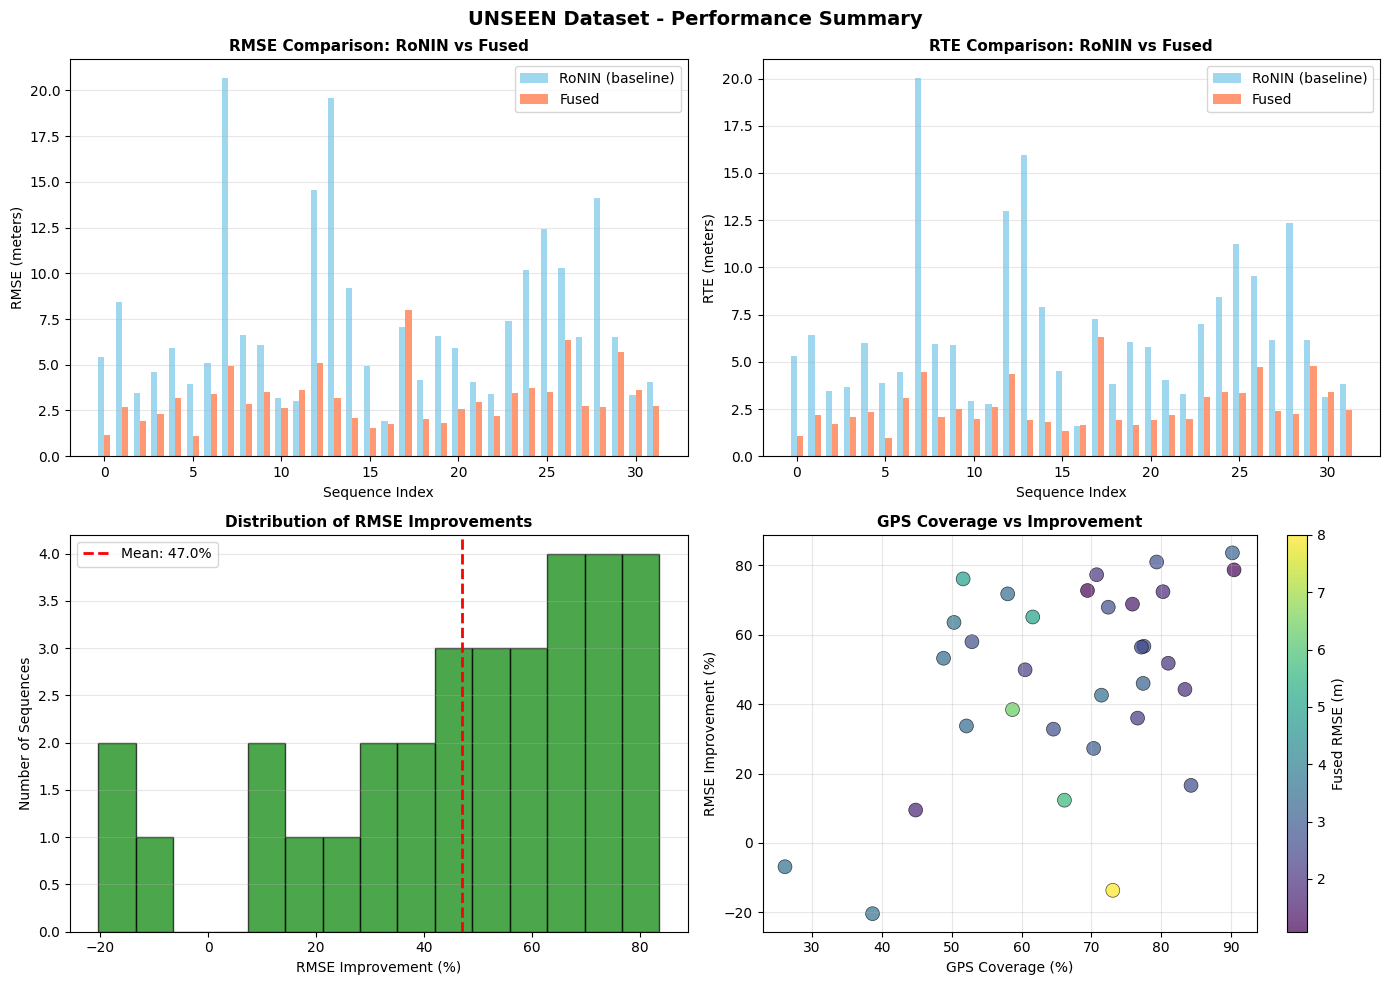


Generating detailed plots for 10 sequences...

Plotting: a050_3
  RMSE: 3.20m (vs 19.58m baseline)
  Improvement: 83.6%
Saved: /content/drive/MyDrive/gps-imu-project/unseen_results/plots/a050_3_detailed.png


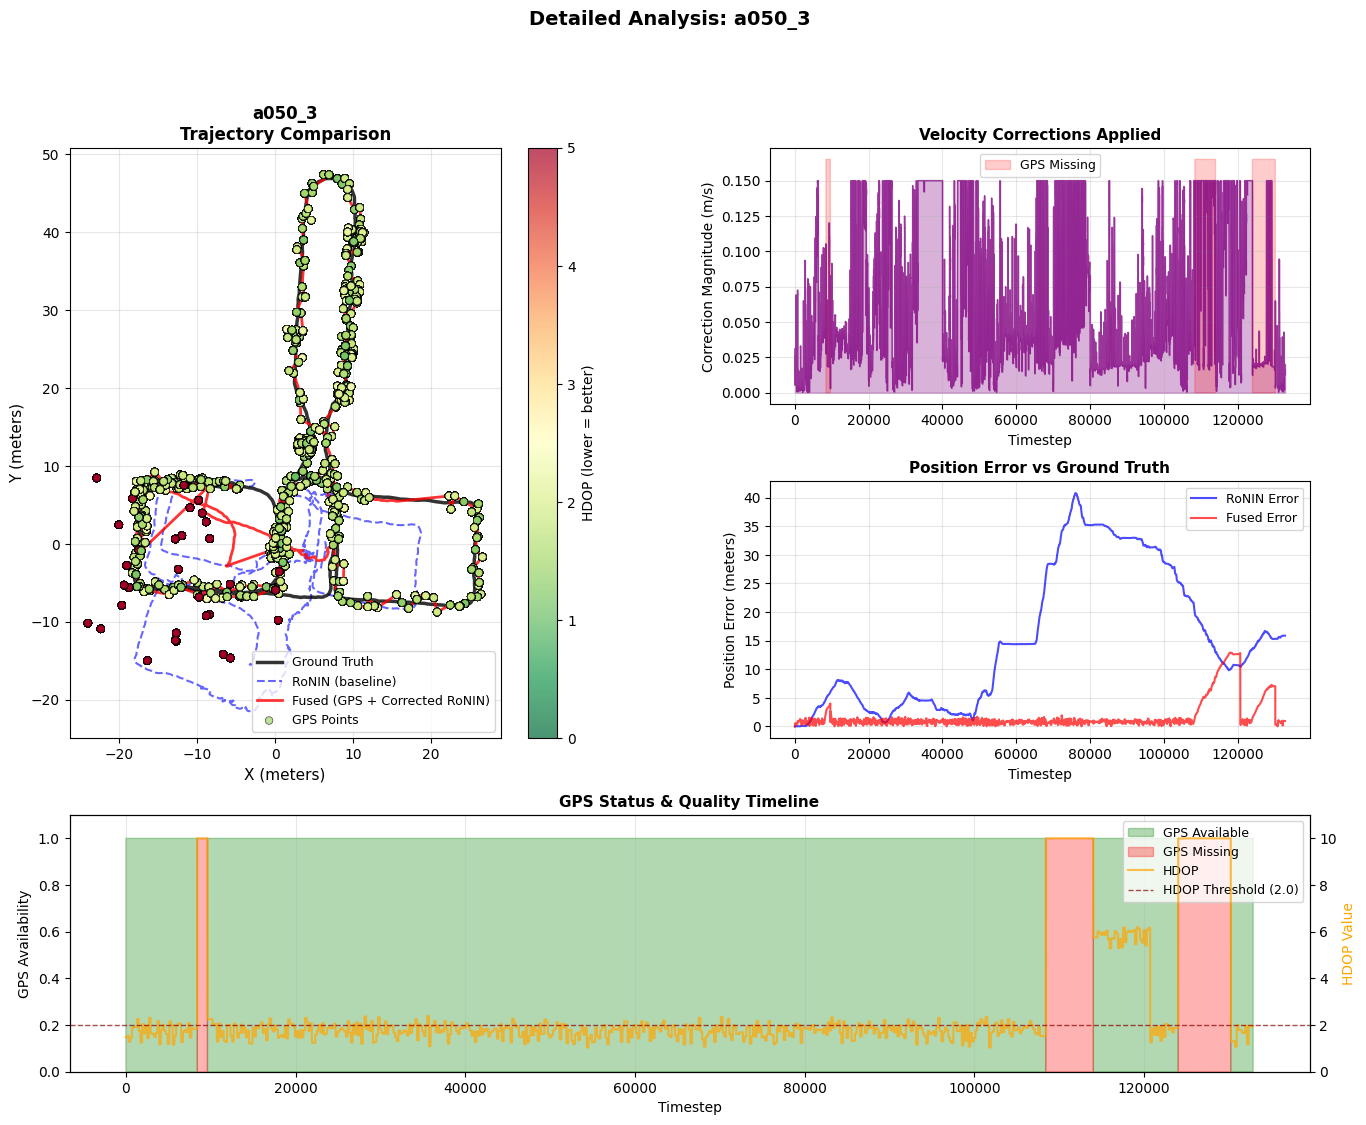


Plotting: a052_2
  RMSE: 8.00m (vs 7.04m baseline)
  Improvement: -13.7%
Saved: /content/drive/MyDrive/gps-imu-project/unseen_results/plots/a052_2_detailed.png


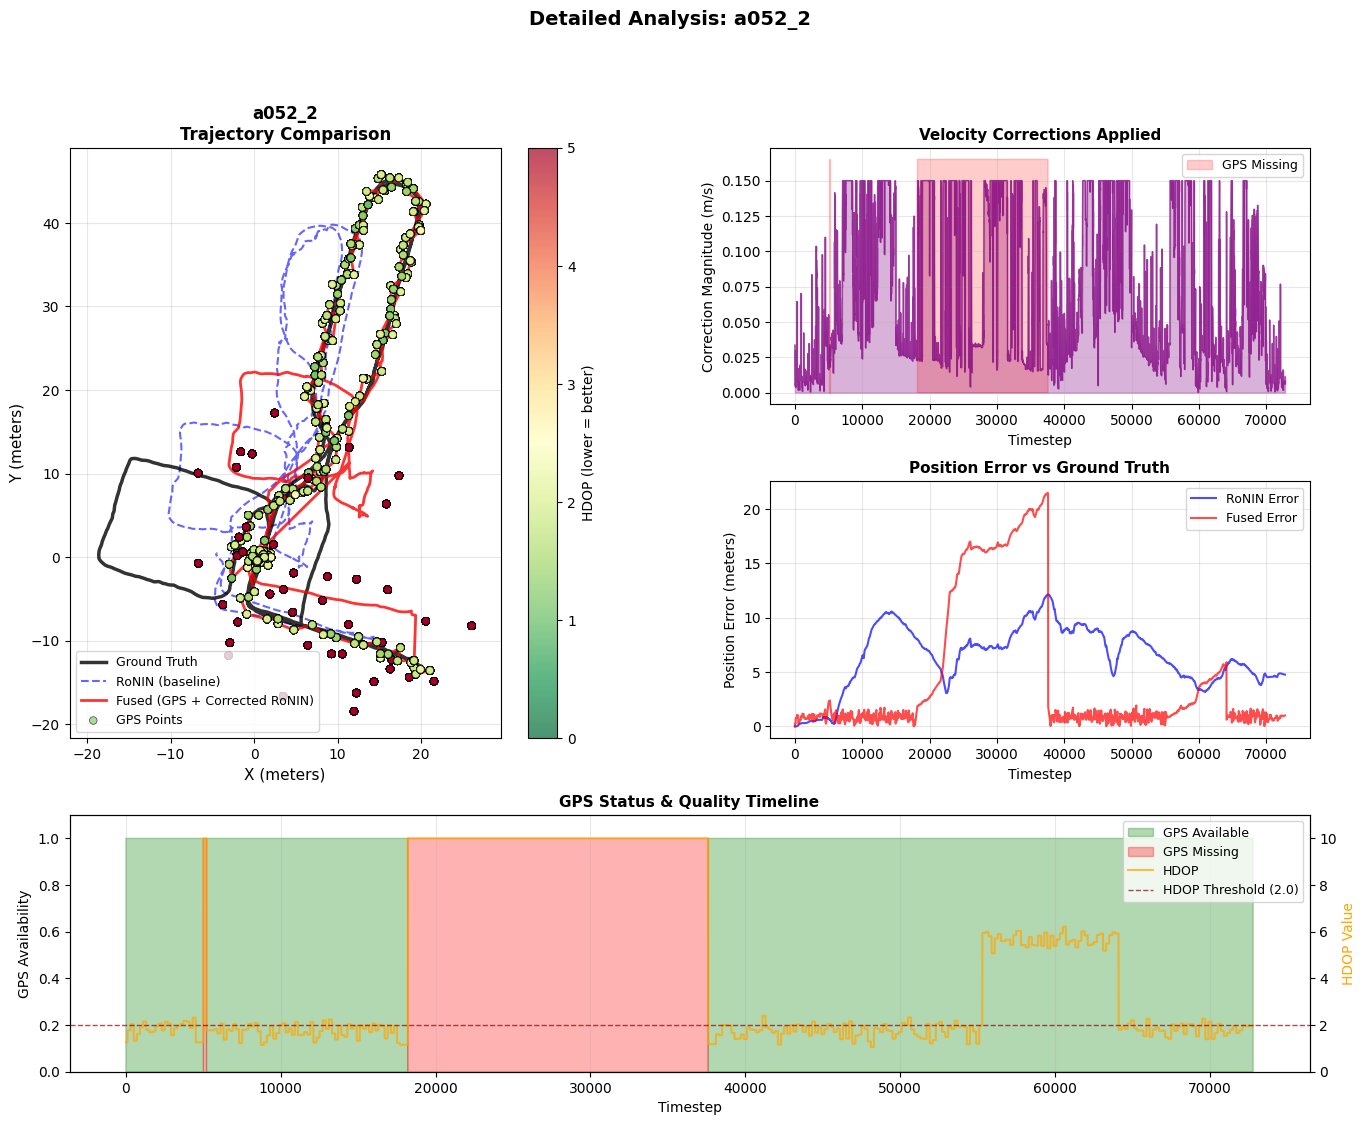


Plotting: a042_2
  RMSE: 2.86m (vs 6.60m baseline)
  Improvement: 56.7%
Saved: /content/drive/MyDrive/gps-imu-project/unseen_results/plots/a042_2_detailed.png


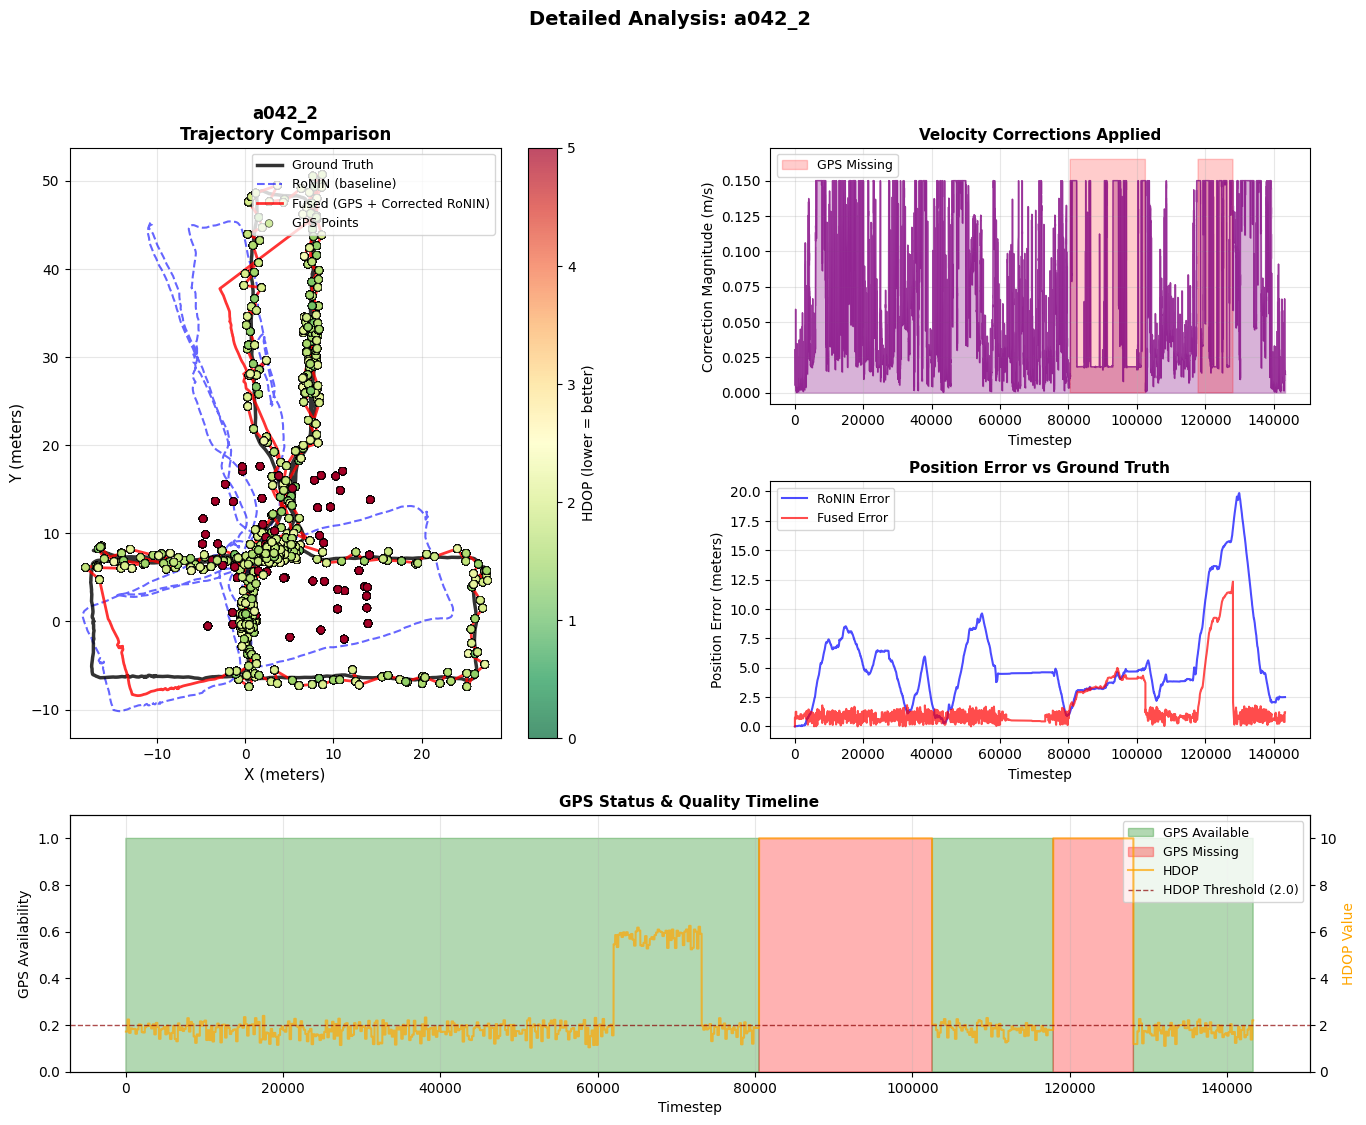


Plotting: a006_2
  RMSE: 1.16m (vs 5.43m baseline)
  Improvement: 78.7%
Saved: /content/drive/MyDrive/gps-imu-project/unseen_results/plots/a006_2_detailed.png


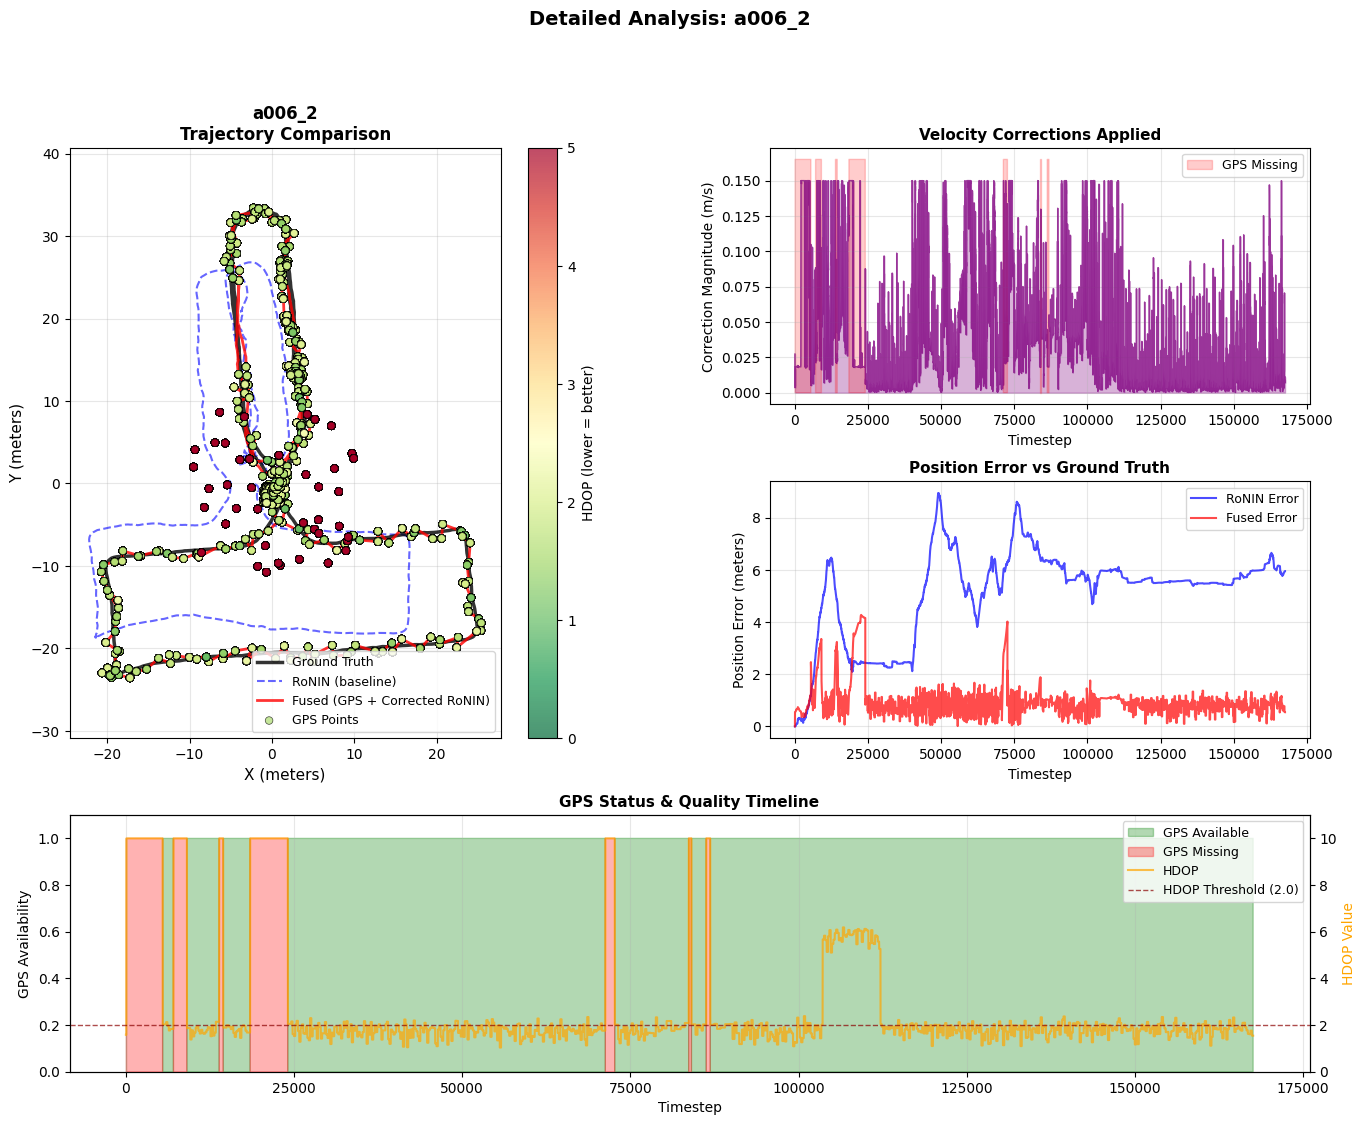


Plotting: a058_2
  RMSE: 3.59m (vs 3.36m baseline)
  Improvement: -6.9%
Saved: /content/drive/MyDrive/gps-imu-project/unseen_results/plots/a058_2_detailed.png


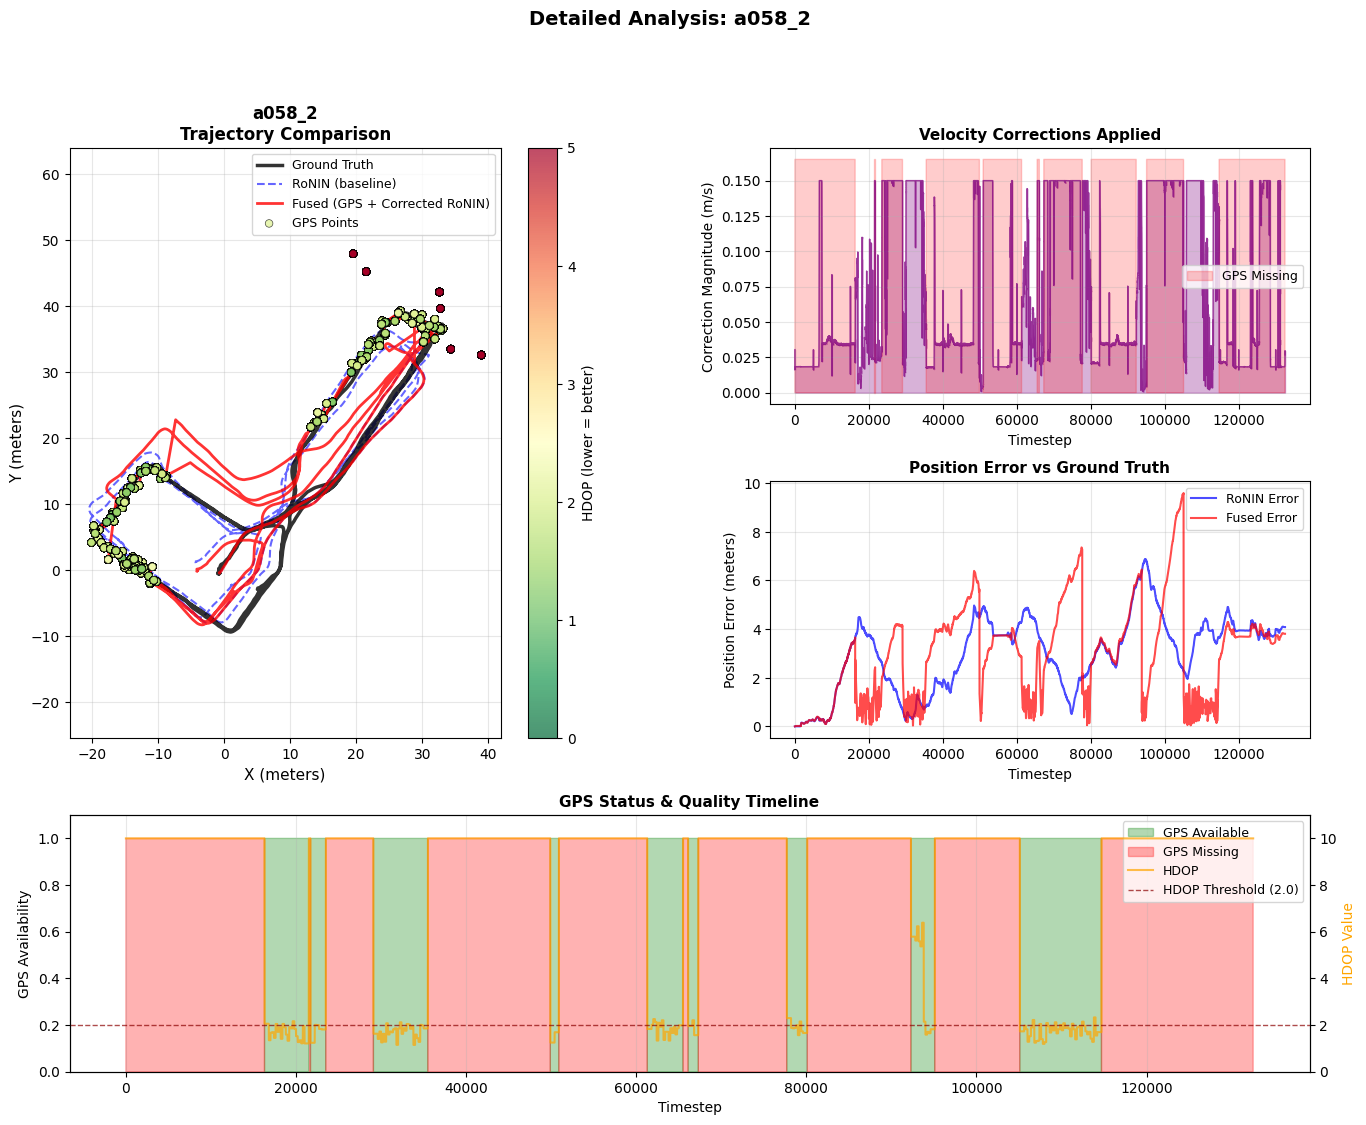


All results saved to: /content/drive/MyDrive/gps-imu-project/unseen_results
TOP 5 BEST IMPROVEMENTS
--------------------------------------------------
seq_name  rmse_ronin  rmse_fused  improvement_rmse  gps_coverage
  a050_3   19.582011    3.204205         83.636997     90.214822
  a057_3   14.140246    2.686175         81.003333     79.366347
  a006_2    5.434885    1.155792         78.733820     90.451752
  a051_1    9.177745    2.079979         77.336712     70.765148
  a032_3   20.660433    4.931493         76.130737     51.632232
TOP 5 WORST PERFORMANCES
--------------------------------------------------
seq_name  rmse_ronin  rmse_fused  improvement_rmse  gps_coverage
  a049_3    3.019803    3.636183        -20.411261     38.653318
  a052_2    7.039977    8.002289        -13.669247     73.076923
  a058_2    3.362806    3.594024         -6.875763     26.106705
  a051_3    1.917390    1.735707          9.475541     44.831976
  a058_1    6.499174    5.698295         12.322782     66

In [12]:
def plot_trajectory_comparison_detailed(seq_data, fused_pos, vel_corrections, save_path=None):
    """
    Detailed 4-panel comparison plot:
    1. Full trajectory comparison
    2. Velocity corrections magnitude
    3. Error over time
    4. GPS availability timeline
    """
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)

    seq_name = seq_data['seq_name']
    gps_mask = np.isfinite(seq_data['gps_pos']).all(axis=1)
    hdop = np.nan_to_num(seq_data['gps_hdop'], nan=10.0)

    # ========== Trajectory Comparison ==========
    ax1 = fig.add_subplot(gs[0:2, 0])

    ax1.plot(seq_data['gt_pos'][:, 0], seq_data['gt_pos'][:, 1],
             'k-', linewidth=2.5, label='Ground Truth', alpha=0.8, zorder=3)

    ax1.plot(seq_data['ronin_pos'][:, 0], seq_data['ronin_pos'][:, 1],
             'b--', linewidth=1.5, label='RoNIN (baseline)', alpha=0.6, zorder=2)

    ax1.plot(fused_pos[:, 0], fused_pos[:, 1],
             'r-', linewidth=2, label='Fused (GPS + Corrected RoNIN)', alpha=0.8, zorder=4)

    gps_valid = seq_data['gps_pos'][gps_mask]
    hdop_valid = hdop[gps_mask]
    scatter = ax1.scatter(gps_valid[:, 0], gps_valid[:, 1],
                         c=hdop_valid, cmap='RdYlGn_r', vmin=0, vmax=5,
                         s=30, label='GPS Points', alpha=0.7,
                         edgecolors='black', linewidth=0.5, zorder=5)

    cbar1 = plt.colorbar(scatter, ax=ax1, label='HDOP (lower = better)')

    ax1.set_xlabel('X (meters)', fontsize=11)
    ax1.set_ylabel('Y (meters)', fontsize=11)
    ax1.set_title(f'{seq_name}\nTrajectory Comparison', fontsize=12, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.axis('equal')

    # ========== Velocity Corrections Magnitude ==========
    ax2 = fig.add_subplot(gs[0, 1])

    correction_mag = np.linalg.norm(vel_corrections, axis=1)
    time_axis = np.arange(len(correction_mag))

    ax2.plot(time_axis, correction_mag, 'purple', linewidth=1, alpha=0.7)
    ax2.fill_between(time_axis, 0, correction_mag, alpha=0.3, color='purple')
    ax2.fill_between(time_axis, 0, correction_mag.max() * 1.1,
                     where=~gps_mask, alpha=0.2, color='red',
                     label='GPS Missing')

    ax2.set_xlabel('Timestep', fontsize=10)
    ax2.set_ylabel('Correction Magnitude (m/s)', fontsize=10)
    ax2.set_title('Velocity Corrections Applied', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    # ========== Position Error Over Time ==========
    ax3 = fig.add_subplot(gs[1, 1])

    error_ronin = np.linalg.norm(seq_data['ronin_pos'] - seq_data['gt_pos'], axis=1)
    error_fused = np.linalg.norm(fused_pos - seq_data['gt_pos'], axis=1)

    ax3.plot(time_axis, error_ronin, 'b-', linewidth=1.5, label='RoNIN Error', alpha=0.7)
    ax3.plot(time_axis, error_fused, 'r-', linewidth=1.5, label='Fused Error', alpha=0.7)

    ax3.set_xlabel('Timestep', fontsize=10)
    ax3.set_ylabel('Position Error (meters)', fontsize=10)
    ax3.set_title('Position Error vs Ground Truth', fontsize=11, fontweight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3)

    # ========== GPS & HDOP Timeline ==========
    ax4 = fig.add_subplot(gs[2, :])

    ax4_twin = ax4.twinx()
    ax4.fill_between(time_axis, 0, 1, where=gps_mask, alpha=0.3,
                     color='green', label='GPS Available', step='mid')
    ax4.fill_between(time_axis, 0, 1, where=~gps_mask, alpha=0.3,
                     color='red', label='GPS Missing', step='mid')

    ax4_twin.plot(time_axis, hdop, 'orange', linewidth=1.5, label='HDOP', alpha=0.7)
    ax4_twin.axhline(y=2.0, color='darkred', linestyle='--', linewidth=1,
                     label='HDOP Threshold (2.0)', alpha=0.7)

    ax4.set_xlabel('Timestep', fontsize=10)
    ax4.set_ylabel('GPS Availability', fontsize=10)
    ax4_twin.set_ylabel('HDOP Value', fontsize=10, color='orange')
    ax4.set_title('GPS Status & Quality Timeline', fontsize=11, fontweight='bold')
    ax4.set_ylim([0, 1.1])
    ax4_twin.set_ylim([0, max(10, hdop.max() * 1.1)])

    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

    ax4.grid(True, alpha=0.3, axis='x')

    plt.suptitle(f'Detailed Analysis: {seq_name}', fontsize=14, fontweight='bold', y=0.995)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()


def plot_metrics_summary(results_df, split_name="UNSEEN", save_path=None):

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # ========== RMSE Comparison ==========
    ax1 = axes[0, 0]
    x = np.arange(len(results_df))
    width = 0.35

    ax1.bar(x - width/2, results_df['rmse_ronin'], width,
            label='RoNIN (baseline)', color='skyblue', alpha=0.8)
    ax1.bar(x + width/2, results_df['rmse_fused'], width,
            label='Fused', color='coral', alpha=0.8)

    ax1.set_xlabel('Sequence Index', fontsize=10)
    ax1.set_ylabel('RMSE (meters)', fontsize=10)
    ax1.set_title('RMSE Comparison: RoNIN vs Fused', fontsize=11, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')

    # ========== RTE Comparison ==========
    ax2 = axes[0, 1]
    ax2.bar(x - width/2, results_df['rte_ronin'], width,
            label='RoNIN (baseline)', color='skyblue', alpha=0.8)
    ax2.bar(x + width/2, results_df['rte_fused'], width,
            label='Fused', color='coral', alpha=0.8)

    ax2.set_xlabel('Sequence Index', fontsize=10)
    ax2.set_ylabel('RTE (meters)', fontsize=10)
    ax2.set_title('RTE Comparison: RoNIN vs Fused', fontsize=11, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # ========== Improvement Distribution ==========
    ax3 = axes[1, 0]
    improvements = results_df['improvement_rmse']
    ax3.hist(improvements, bins=15, color='green', alpha=0.7, edgecolor='black')
    ax3.axvline(improvements.mean(), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {improvements.mean():.1f}%')

    ax3.set_xlabel('RMSE Improvement (%)', fontsize=10)
    ax3.set_ylabel('Number of Sequences', fontsize=10)
    ax3.set_title('Distribution of RMSE Improvements', fontsize=11, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # ========== GPS Coverage vs Improvement ==========
    ax4 = axes[1, 1]
    scatter = ax4.scatter(results_df['gps_coverage'], results_df['improvement_rmse'],
                         s=100, c=results_df['rmse_fused'], cmap='viridis',
                         alpha=0.7, edgecolors='black', linewidth=0.5)

    ax4.set_xlabel('GPS Coverage (%)', fontsize=10)
    ax4.set_ylabel('RMSE Improvement (%)', fontsize=10)
    ax4.set_title('GPS Coverage vs Improvement', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    cbar = plt.colorbar(scatter, ax=ax4, label='Fused RMSE (m)')

    plt.suptitle(f'{split_name} Dataset - Performance Summary',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()


def test_on_unseen_dataset(model, num_samples_to_plot=3):
    """
    Complete testing pipeline:
    1. Load unseen sequences
    2. Run inference
    3. Compute metrics
    4. Create visualizations
    5. Save results
    """

    print("\nLoading UNSEEN sequences...")
    unseen_names = [f.stem.replace('_gsn','') for f in Path(RONIN_UNSEEN_DIR).glob('*_gsn.npy')]
    unseen_aligned = load_aligned_sequences(unseen_names, RONIN_UNSEEN_DIR, UNSEEN_DIR)

    print(f"Loaded {len(unseen_aligned)} unseen sequences\n")

    plot_dir = Path(PROJECT_DIR) / 'unseen_results' / 'plots'
    plot_dir.mkdir(parents=True, exist_ok=True)

    results = []
    sequences_for_plotting = []

    model.eval()

    for seq in tqdm(unseen_aligned, desc="Testing on UNSEEN"):

        fused_pos, corrections, gps_mask = predict_sequence_with_corrections(
            model, seq, device
        )

        rmse_fused = compute_rmse(fused_pos, seq['gt_pos'])
        rte_fused = compute_rte(fused_pos, seq['gt_pos'], seq['time'], window_sec=60.0)

        rmse_ronin = compute_rmse(seq['ronin_pos'], seq['gt_pos'])
        rte_ronin = compute_rte(seq['ronin_pos'], seq['gt_pos'], seq['time'])

        gps_coverage = gps_mask.mean() * 100
        improvement = ((rmse_ronin - rmse_fused) / rmse_ronin * 100) if rmse_ronin > 0 else 0

        results.append({
            'seq_name': seq['seq_name'],
            'rmse_fused': rmse_fused,
            'rte_fused': rte_fused,
            'rmse_ronin': rmse_ronin,
            'rte_ronin': rte_ronin,
            'gps_coverage': gps_coverage,
            'improvement_rmse': improvement
        })

        sequences_for_plotting.append({
            'seq_data': seq,
            'fused_pos': fused_pos,
            'corrections': corrections,
            'metrics': results[-1]
        })

    results_df = pd.DataFrame(results)

    print(f"\n**Fused Trajectory (GPS + Corrected RoNIN):**")
    print(f"  Mean RMSE: {results_df['rmse_fused'].mean():.3f} ± {results_df['rmse_fused'].std():.3f} m")
    print(f"  Median RMSE: {results_df['rmse_fused'].median():.3f} m")
    print(f"  Mean RTE: {results_df['rte_fused'].mean():.3f} ± {results_df['rte_fused'].std():.3f} m")

    print(f"\n**Baseline (RoNIN alone):**")
    print(f"  Mean RMSE: {results_df['rmse_ronin'].mean():.3f} ± {results_df['rmse_ronin'].std():.3f} m")
    print(f"  Median RMSE: {results_df['rmse_ronin'].median():.3f} m")
    print(f"  Mean RTE: {results_df['rte_ronin'].mean():.3f} ± {results_df['rte_ronin'].std():.3f} m")

    print(f"\n**Improvement:**")
    print(f"  Mean RMSE reduction: {results_df['improvement_rmse'].mean():.1f}%")
    print(f"  Sequences improved: {(results_df['improvement_rmse'] > 0).sum()}/{len(results_df)}")
    print(f"  Mean GPS coverage: {results_df['gps_coverage'].mean():.1f}%")

    csv_path = Path(PROJECT_DIR) / 'unseen_results' / 'metrics.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"\nResults saved to: {csv_path}")


    summary_plot_path = Path(PROJECT_DIR) / 'unseen_results' / 'summary_metrics.png'
    plot_metrics_summary(results_df, split_name="UNSEEN", save_path=summary_plot_path)

    print(f"\nGenerating detailed plots for {num_samples_to_plot} sequences...")

    indices_to_plot = []

    if len(results_df) > 0:
        indices_to_plot.append(results_df['improvement_rmse'].idxmax())  # Best
        if len(results_df) > 1:
            indices_to_plot.append(results_df['rmse_fused'].idxmax())  # Worst
        if len(results_df) > 2:
            indices_to_plot.append(results_df['rmse_fused'].sub(results_df['rmse_fused'].median()).abs().idxmin())  # Median
        if len(results_df) > 3:
            indices_to_plot.append(results_df['gps_coverage'].idxmax())  # High GPS
        if len(results_df) > 4:
            indices_to_plot.append(results_df['gps_coverage'].idxmin())  # Low GPS

    indices_to_plot = list(dict.fromkeys(indices_to_plot))[:num_samples_to_plot]

    for idx in indices_to_plot:
        seq_result = sequences_for_plotting[idx]
        seq_name = seq_result['seq_data']['seq_name']

        print(f"\nPlotting: {seq_name}")
        print(f"  RMSE: {seq_result['metrics']['rmse_fused']:.2f}m (vs {seq_result['metrics']['rmse_ronin']:.2f}m baseline)")
        print(f"  Improvement: {seq_result['metrics']['improvement_rmse']:.1f}%")

        save_path = plot_dir / f'{seq_name}_detailed.png'
        plot_trajectory_comparison_detailed(
            seq_result['seq_data'],
            seq_result['fused_pos'],
            seq_result['corrections'],
            save_path=save_path
        )

    print(f"\nAll results saved to: {Path(PROJECT_DIR) / 'unseen_results'}")

    return results_df, sequences_for_plotting


model.load_state_dict(torch.load(f'{PROJECT_DIR}/velocity_correction_model.pth'))
model.eval()

unseen_results_df, unseen_sequences = test_on_unseen_dataset(
    model,
    num_samples_to_plot=10
)


print("TOP 5 BEST IMPROVEMENTS")
print("-"*50)
print(unseen_results_df.nlargest(5, 'improvement_rmse')[
    ['seq_name', 'rmse_ronin', 'rmse_fused', 'improvement_rmse', 'gps_coverage']
].to_string(index=False))


print("TOP 5 WORST PERFORMANCES")
print("-"*50)
print(unseen_results_df.nsmallest(5, 'improvement_rmse')[
    ['seq_name', 'rmse_ronin', 'rmse_fused', 'improvement_rmse', 'gps_coverage']
].to_string(index=False))